# Next week

## ToDo
---
> figure out proper order of data processing from raw data filtering to feature creation
---

- filter uncorrelated features at the beggining (just after dropping columns with > 20% nan)
- deal with the rest nan's (already done - garrage, electrical, bsmt, etc.)
- change remaining columns into features 
    - automate this process???

In [15]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import phik

In [16]:
# Matplotlib setting to increase font size
plt.rcParams.update({'font.size': 12})

In [17]:
# Road raw training data
raw_data = pd.read_csv('train.csv', index_col=0)
raw_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Use `pandas_profiling` library to create neat summary of data as html report 
```python
profile = pp.ProfileReport(raw_data, title="Profile")
profile.to_file("profile_report.html")
```

In [18]:
# Create copy not to work on raw data
data = raw_data.copy()

# Exclude columns with > 20% missing values
threshold = 0.2
data = data[data.columns[data.isnull().mean() < threshold]]
data.shape

(1460, 75)

In [19]:
corr = data.phik_matrix()

interval columns not set, guessing: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


UnicodeEncodeError: 'ascii' codec can't encode character '\u0142' in position 22: ordinal not in range(128)

NameError: name 'corr' is not defined

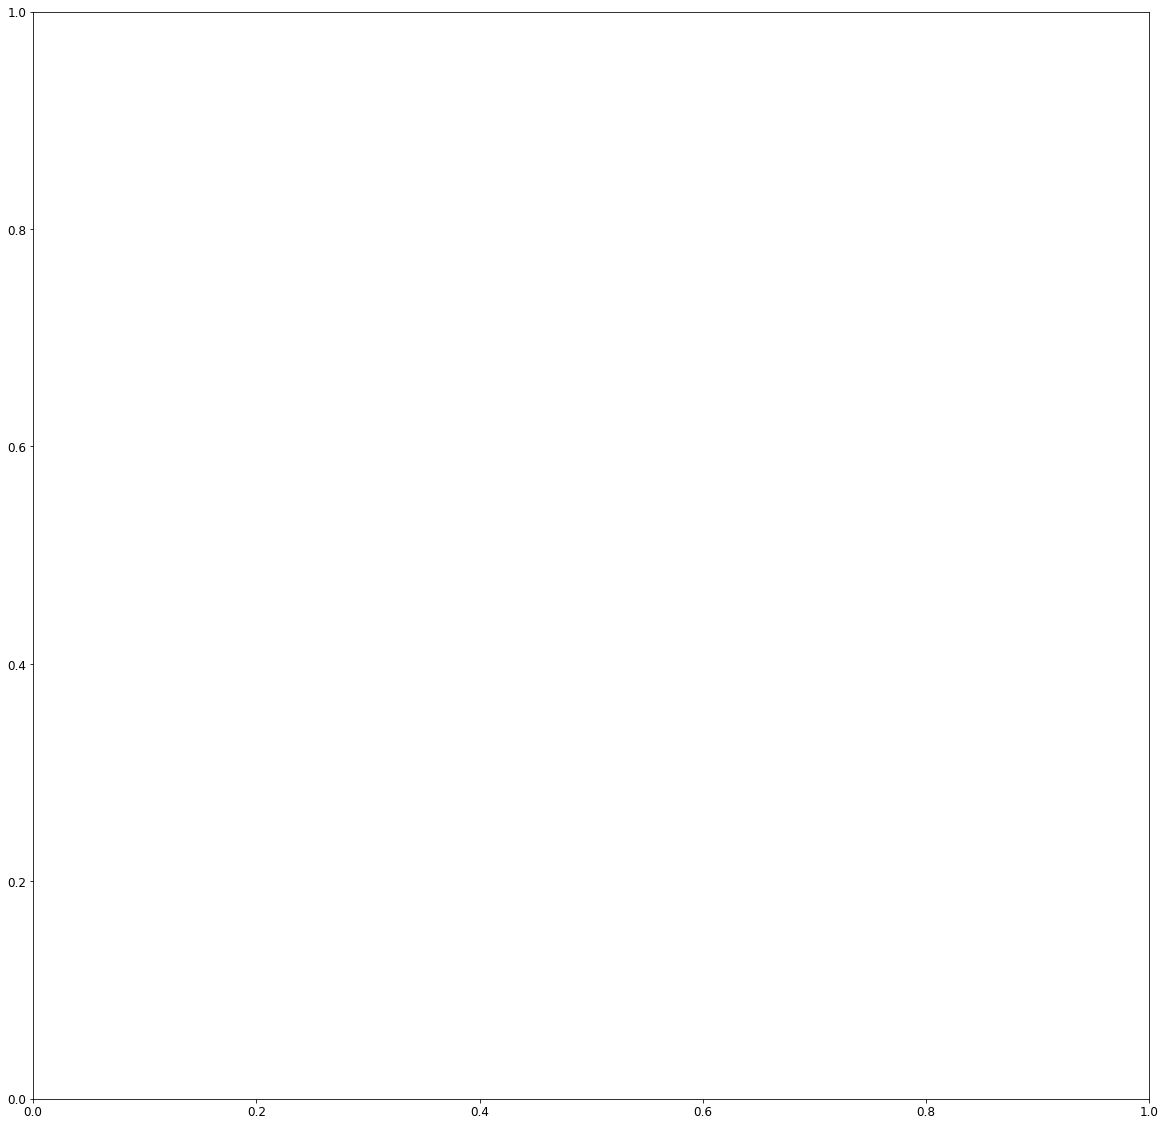

In [20]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor='w')
sns.heatmap(corr, ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')

### Useful snippets 

- check columns with missing values (along with their total number in each column)

```data.isna().sum()[lambda x: x > 0]```

- factorize categorical values into numerical 

```df = df.apply(lambda x : pd.factorize(x)[0])```

In [21]:
# Impute NaNs with median
data.LotFrontage = data.LotFrontage.fillna(data.LotFrontage.median()) 

# Create single variable encoding if the garage is present
data["Garage"] = ~data["GarageType"].isna() * 1
data = data.drop(data.filter(regex='Garage.').columns, axis=1)

### Explore features related to basement information

interval columns not set, guessing: ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'SalePrice']


UnicodeEncodeError: 'ascii' codec can't encode character '\u0142' in position 22: ordinal not in range(128)

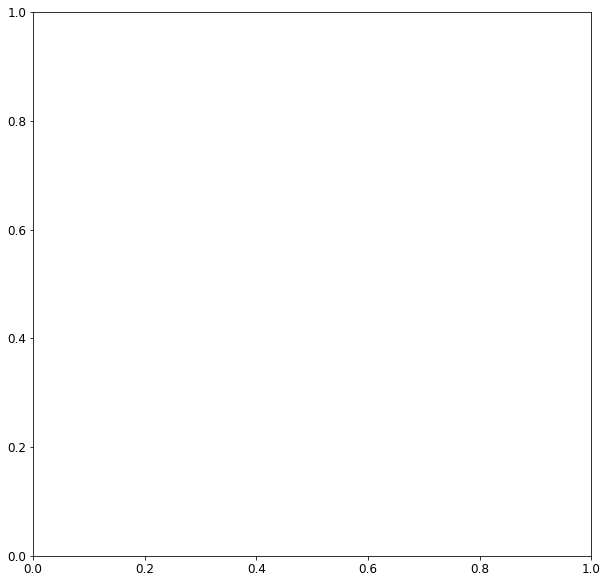

In [22]:
# Investigate correlations among basement variables and price
fig, ax = plt.subplots(figsize=(10, 10), facecolor='w')

data_bsmt = data.filter(regex='Bsmt|SalePrice')

# Use phik method to handle both categorical and numerical values
corr_bsmt = data_bsmt.phik_matrix()

sns.heatmap(corr_bsmt, annot=True, ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', 
            fmt='.2f')

In [23]:
# Remove all features that have correlation with SalePrice smaller than threshold
threshold = 0.2

columns_to_drop = corr_bsmt.loc['SalePrice', :] < threshold
columns_to_drop = columns_to_drop[columns_to_drop].index

data = data.drop(list(columns_to_drop), axis=1)

NameError: name 'corr_bsmt' is not defined

```
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches)
       NA	No Basement
       
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
       
BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
       
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
```

- TODO: check how `inplace` impact performance
- TODO: check if `drop_first` impact model performance / accuracy?

In [24]:
get_mapping = lambda order: {idx: label for label, idx in enumerate(order)}

# Create new feature encoding presence of basement
data['Bsmt'] = ~data['BsmtQual'].isna() * 1

mapping = get_mapping([np.nan, 'Po', 'Fa', 'TA', 'Gd', 'Ex'])
data['BsmtQual'] = data['BsmtQual'].replace(mapping)
data['BsmtCond'] = data['BsmtCond'].replace(mapping)

mapping = get_mapping([np.nan, 'No', 'Mn', 'Av', 'Gd'])
data['BsmtExposure'] = data['BsmtExposure'].replace(mapping)

mapping = get_mapping([np.nan, 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'])
data['BsmtFinType1'] = data['BsmtFinType1'].replace(mapping)

In [25]:
# Impute nan's with 'None' and convert categorical variable into dummies 
mas_vnr_dummies = pd.get_dummies(data['MasVnrType'], prefix='MasVnrType', 
                                 prefix_sep='_', drop_first=True)

data['MasVnrType'] = data['MasVnrType'].fillna('None')
data = pd.concat([data, mas_vnr_dummies], axis=1)

data['MasVnrArea'] = data['MasVnrType'].fillna(0)

**Fuse feature** is separated into two separate features: 

    - first feature `Electrical_Fuse` is binary and code presence of fuse-type electrical system
    - second feature `Electrical_Fuse_Rank` is numerical with values ranging from 0 to 3 and ranks fuse-type systems in terms of their quality


In [26]:
# Create new categorical and numerical features from Electrical column
data['Electrical_Fuse'] = data['Electrical'].str.startswith('Fuse') * 1
data['Electrical_Fuse'] = data['Electrical_Fuse'].fillna(0)
data['Electrical_Fuse_Rank'] = data['Electrical'].map(mapping).fillna(0)

data['Electrical_SBrkr'] = (data['Electrical'] == 'SBrkr').astype(int)
data['Electrical_Mix'] = (data['Electrical'] == 'Mix').astype(int)

data = data.drop('Electrical', axis=1)

In [27]:
data.isna().sum()[lambda x: x > 0]

BsmtFinType2    38
dtype: int64

y = X * b + err 

In [55]:
zmienna = data[data['LotFrontage'] < 50]['MSSubClass']
zmienna

Id
24      120
29       20
47       50
49      190
57      160
       ... 
1406    120
1410     60
1423    120
1450    180
1453    180
Name: MSSubClass, Length: 148, dtype: int64

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SalePrice,Garage,Bsmt,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Electrical_Fuse,Electrical_Fuse_Rank,Electrical_SBrkr,Electrical_Mix
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,208500,1,1,1,0,0,0,0.0,1,0
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,181500,1,1,0,1,0,0,0.0,1,0
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,223500,1,1,1,0,0,0,0.0,1,0
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,140000,1,1,0,1,0,0,0.0,1,0
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,250000,1,1,1,0,0,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,175000,1,1,0,1,0,0,0.0,1,0
1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,210000,1,1,0,0,1,0,0.0,1,0
1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,266500,1,1,0,1,0,0,0.0,1,0
